<a href="https://colab.research.google.com/github/anushirahatti/housing-price-prediction-app/blob/master/notebook/Housing_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ingest

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, r2_score, confusion_matrix, accuracy_score
import statsmodels.formula.api as sm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import sklearn.ensemble as ske
from google.colab import files

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
#Autheticate E-Mail ID

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# EDA

In [0]:
#Get File from Drive using file-ID

#2.1 Get the Zillow file
downloaded = drive.CreateFile({'id':'1VkaBwlaXR90PWZtNiJtr4Eg3RVwpnlwi'}) # replace the id with id of file you want to access
downloaded.GetContentFile('Zillow.csv') 
#2.2 Get the minum wage file
download = drive.CreateFile({'id':'1Wy1U-aWNw0xP26Kg2YwvIG5UiOWnMHa6'}) # replace the id with id of file you want to access
download.GetContentFile('Minimum Wage Data.csv')

In [5]:
# Read House Price dataset

df1 = pd.read_csv('Zillow.csv')
df1.head()

,State,Average,Year,State.1
0,AK,127666.00,1996,Alaska
1,AL,82996.00,1996,Alabama
2,AR,69353.67,1996,Arkansas
3,AZ,110715.08,1996,Arizona
4,CA,161508.92,1996,California


In [6]:
# Read Minimum Wage dataset

df2 = pd.read_csv('Minimum Wage Data.csv',encoding='windows-1252')
df2.head()

,Year,State,Table_Data,Footnote,High.Value,Low.Value,CPI.Average,High.2018,Low.2018
0,1968,Alabama,...,NaN,0.00000,0.00000,34.783333,0.00,0.00
1,1968,Alaska,2.10,NaN,2.10000,2.10000,34.783333,15.12,15.12
2,1968,Arizona,18.72 - 26.40/wk(b),(b),0.66000,0.46800,34.783333,4.75,3.37
3,1968,Arkansas,1.25/day(b),(b),0.15625,0.15625,34.783333,1.12,1.12
4,1968,California,1.65(b),(b),1.65000,1.65000,34.783333,11.88,11.88


In [7]:
# Merge two datasets
df = pd.merge(left=df1, right=df2, left_on=['State.1','Year'], right_on=['State','Year'])
df.head()

,State_x,Average,Year,State.1,State_y,Table_Data,Footnote,High.Value,Low.Value,CPI.Average,High.2018,Low.2018
0,AK,127666.00,1996,Alaska,Alaska,4.75,NaN,4.75,4.75,156.85,7.58,7.58
1,AL,82996.00,1996,Alabama,Alabama,...,NaN,0.00,0.00,156.85,0.00,0.00
2,AR,69353.67,1996,Arkansas,Arkansas,4.25[c],[c],4.25,4.25,156.85,6.78,6.78
3,AZ,110715.08,1996,Arizona,Arizona,...,NaN,0.00,0.00,156.85,0.00,0.00
4,CA,161508.92,1996,California,California,4.25,NaN,4.25,4.25,156.85,6.78,6.78


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122 entries, 0 to 1121
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   State_x      1122 non-null   object 
 1   Average      1122 non-null   float64
 2   Year         1122 non-null   int64  
 3   State.1      1122 non-null   object 
 4   State_y      1122 non-null   object 
 5   Table_Data   1122 non-null   object 
 6   Footnote     262 non-null    object 
 7   High.Value   1122 non-null   float64
 8   Low.Value    1122 non-null   float64
 9   CPI.Average  1122 non-null   float64
 10  High.2018    1122 non-null   float64
 11  Low.2018     1122 non-null   float64
dtypes: float64(6), int64(1), object(5)
memory usage: 114.0+ KB


In [9]:
df.tail()

,State_x,Average,Year,State.1,State_y,Table_Data,Footnote,High.Value,Low.Value,CPI.Average,High.2018,Low.2018
1117,VT,237576.83,2017,Vermont,Vermont,10.00(e),(e),10.00,10.00,245.119583,10.22,10.22
1118,WA,354112.75,2017,Washington,Washington,11.00,NaN,11.00,11.00,245.119583,11.24,11.24
1119,WI,173616.08,2017,Wisconsin,Wisconsin,7.25,NaN,7.25,7.25,245.119583,7.41,7.41
1120,WV,98851.92,2017,West Virginia,West Virginia,8.75,NaN,8.75,8.75,245.119583,8.94,8.94
1121,WY,227486.42,2017,Wyoming,Wyoming,5.15,NaN,5.15,5.15,245.119583,5.26,5.26


In [10]:
df.describe()

,Average,Year,High.Value,Low.Value,CPI.Average,High.2018,Low.2018
count,1122.000000,1122.000000,1122.000000,1122.000000,1122.000000,1122.000000,1122.000000
mean,177338.170873,2006.500000,5.543048,5.416667,202.155644,6.789073,6.640428
std,88386.761283,6.347118,2.489695,2.517142,28.360432,2.728561,2.785009
min,0.000000,1996.000000,0.000000,0.000000,156.850000,0.000000,0.000000
25%,118233.940000,2001.000000,5.150000,4.750000,177.066667,6.630000,6.400000
50%,154413.000000,2006.500000,5.650000,5.215000,204.467042,7.640000,7.560000
75%,220759.480000,2012.000000,7.250000,7.250000,229.593917,8.330000,8.330000
max,607579.080000,2017.000000,11.500000,11.500000,245.119583,12.000000,12.000000


In [11]:
df.shape

(1122, 12)

In [12]:
df[df.State_y == 'California']

,State_x,Average,Year,State.1,State_y,Table_Data,Footnote,High.Value,Low.Value,CPI.Average,High.2018,Low.2018
4,CA,161508.92,1996,California,California,4.25,NaN,4.25,4.25,156.850000,6.78,6.78
55,CA,164423.92,1997,California,California,4.75,NaN,4.75,4.75,160.516667,7.41,7.41
106,CA,177379.25,1998,California,California,5.15,NaN,5.15,5.15,163.008333,7.91,7.91
157,CA,193382.67,1999,California,California,5.15,NaN,5.15,5.15,166.575000,7.74,7.74
208,CA,216956.33,2000,California,California,5.75,NaN,5.75,5.75,172.200000,8.36,8.36
259,CA,247351.67,2001,California,California,6.25,NaN,6.25,6.25,177.066667,8.84,8.84
310,CA,278382.92,2002,California,California,6.75,NaN,6.75,6.75,179.875000,9.40,9.40
361,CA,324651.33,2003,California,California,6.75,NaN,6.75,6.75,183.958333,9.19,9.19
412,CA,395634.83,2004,California,California,6.75,NaN,6.75,6.75,188.883333,8.95,8.95
463,CA,480682.17,2005,California,California,6.75,NaN,6.75,6.75,195.291667,8.65,8.65


# Pre-processing

In [0]:
# Drop unnecessary columns
df = df.drop(['State_x','State.1','Table_Data','Footnote'], axis=1)

In [14]:
# Create a new function to find missing values
def num_missing(x):
    return sum(x.isnull())

# Applying per column:
print("Missing values per column:")
# Check how many are missing by column, and then check which ones have any missing values
print(df.apply(num_missing, axis=0).where(lambda x : x != 0).dropna().head(20)) 
# axis=0 defines that function is to be applied on each column

Missing values per column:
Series([], dtype: float64)


In [15]:
print(df.dtypes)

Average        float64
Year             int64
State_y         object
High.Value     float64
Low.Value      float64
CPI.Average    float64
High.2018      float64
Low.2018       float64
dtype: object


In [16]:
#How many states are in the data?
number_of_states = np.unique(df['State_y']).tolist()
print ("The states in the data are: ", number_of_states)
print ("\nTotal number of states: ", len(number_of_states))

The states in the data are:  ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

Total number of states:  51


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6303daf60>]],
      dtype=object)

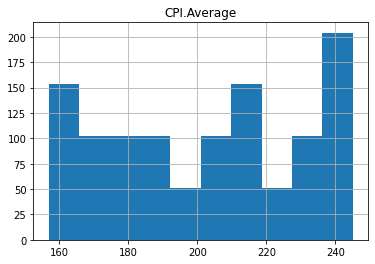

In [17]:
# Check the distribution of numeric variables (CPI.Average)
df.hist('CPI.Average')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc62f891eb8>]],
      dtype=object)

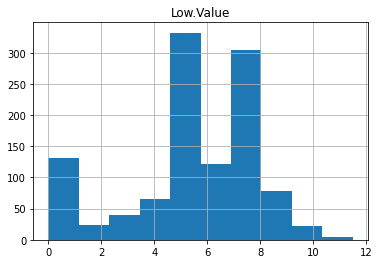

In [18]:
# Check the distribution of numeric variables (Low.Value)
df.hist('Low.Value')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc62f3c9748>]],
      dtype=object)

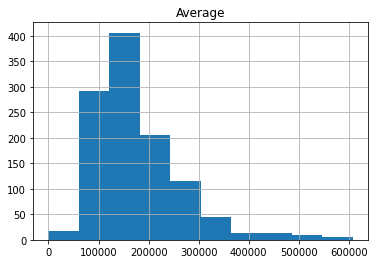

In [19]:
# Check the distribution of numeric variables (Average)
df.hist('Average')

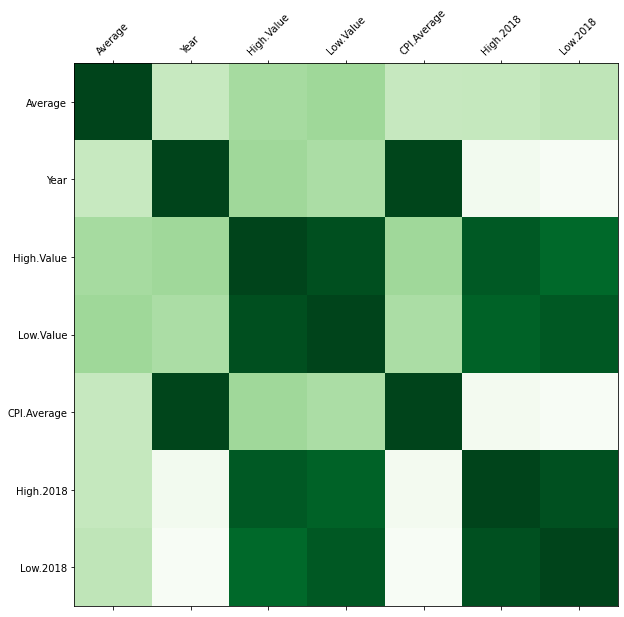

In [20]:
# Check for multicollinearity of variables
def plot_corr(df,size=10):
    corr = df.corr()  #the default method is pearson
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr,cmap=plt.cm.Greens)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)    
    plt.show()
plot_corr(df, size=10)

In [0]:
# Remove observation with zero values for Average and Low.Value
df = df[df['Average'] > 0] 
df = df[df['Low.Value'] > 0] 

In [22]:
df.shape

(973, 8)

In [23]:
df.describe()

,Average,Year,High.Value,Low.Value,CPI.Average,High.2018,Low.2018
count,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000
mean,187557.280504,2006.768756,6.308428,6.163875,203.379911,7.703936,7.534245
std,88578.829680,6.298880,1.542608,1.659778,28.132663,1.221646,1.469143
min,61166.580000,1996.000000,1.600000,1.600000,156.850000,2.260000,2.040000
25%,123447.330000,2001.000000,5.150000,5.150000,177.066667,7.010000,6.830000
50%,164905.000000,2007.000000,6.250000,6.250000,207.342417,7.760000,7.740000
75%,229893.580000,2012.000000,7.250000,7.250000,229.593917,8.390000,8.360000
max,607579.080000,2017.000000,11.500000,11.500000,245.119583,12.000000,12.000000


In [0]:
# Create dummy variables for State
df = pd.get_dummies(df, columns=['State_y'], drop_first=True)

In [25]:
df.head()

,Average,Year,High.Value,Low.Value,CPI.Average,High.2018,Low.2018,State_y_Arizona,State_y_Arkansas,State_y_California,State_y_Colorado,State_y_Connecticut,State_y_Delaware,State_y_District of Columbia,State_y_Florida,State_y_Georgia,State_y_Hawaii,State_y_Idaho,State_y_Illinois,State_y_Indiana,State_y_Iowa,State_y_Kansas,State_y_Kentucky,State_y_Maine,State_y_Maryland,State_y_Massachusetts,State_y_Michigan,State_y_Minnesota,State_y_Missouri,State_y_Montana,State_y_Nebraska,State_y_Nevada,State_y_New Hampshire,State_y_New Jersey,State_y_New Mexico,State_y_New York,State_y_North Carolina,State_y_North Dakota,State_y_Ohio,State_y_Oklahoma,State_y_Oregon,State_y_Pennsylvania,State_y_Rhode Island,State_y_South Dakota,State_y_Texas,State_y_Utah,State_y_Vermont,State_y_Virginia,State_y_Washington,State_y_West Virginia,State_y_Wisconsin,State_y_Wyoming
0,127666.00,1996,4.75,4.75,156.85,7.58,7.58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,69353.67,1996,4.25,4.25,156.85,6.78,6.78,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,161508.92,1996,4.25,4.25,156.85,6.78,6.78,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,142677.83,1996,3.00,3.00,156.85,4.79,4.79,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,149685.33,1996,4.27,4.27,156.85,6.82,6.82,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Model

### Training and Test dataset

In [0]:
#The goal is to predict the average housing price given year, CPI.Avg, state and Low.Value
#Since we'll be using supervised learning we need to create training and test datasets
pd.options.mode.chained_assignment = None  # default='warn'
# Define our dependent variable
y_column = 'Average'
y = df[y_column]
# Define our independent variables
x_columns = df.drop(['Average','High.Value','High.2018','Low.2018'], axis = 1) 
X = x_columns
# Add an intercept term to the independent variables. This is needed in order to include the constant term from
# linear regression equation.
X['intercept'] = 1
# Split our data into training and test data sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
#The goal is to predict the average housing price given year, CPI.Avg and Low.Value
#Since we'll be using supervised learning we need to create training and test datasets
pd.options.mode.chained_assignment = None  # default='warn'

# Define our dependent variable
y_column = 'Average'
y = df[y_column]
# Define our independent variables
x_columns = ['Year','Low.Value','CPI.Average']
X = df[x_columns]
# Add an intercept term to the independent variables. This is needed in order to include the constant term from
# linear regression equation.
X['intercept'] = 1
# Split our data into training and test data sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression

In [28]:
#check the model summary
model = sm.OLS(endog=y1_train, exog=X1_train)
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                Average   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     61.36
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.89e-222
Time:                        23:29:38   Log-Likelihood:                -9350.5
No. Observations:                 778   AIC:                         1.880e+04
Df Residuals:                     729   BIC:                         1.903e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Year            

In [29]:
#check the model summary
model = sm.OLS(endog=y2_train, exog=X2_train)
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                Average   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     106.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.22e-57
Time:                        23:29:38   Log-Likelihood:                -9845.5
No. Observations:                 778   AIC:                         1.970e+04
Df Residuals:                     774   BIC:                         1.972e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Year        -8784.3272   4749.665     -1.849      

In [0]:
# dividing Average into 4 categories: low , medium, high and very high
df["New_Avg"]=pd.cut(df["Average"], bins=[0,130000,260000,400000,600000],labels=['low','medium','high','very_high'])

In [31]:
df.head()

,Average,Year,High.Value,Low.Value,CPI.Average,High.2018,Low.2018,State_y_Arizona,State_y_Arkansas,State_y_California,State_y_Colorado,State_y_Connecticut,State_y_Delaware,State_y_District of Columbia,State_y_Florida,State_y_Georgia,State_y_Hawaii,State_y_Idaho,State_y_Illinois,State_y_Indiana,State_y_Iowa,State_y_Kansas,State_y_Kentucky,State_y_Maine,State_y_Maryland,State_y_Massachusetts,State_y_Michigan,State_y_Minnesota,State_y_Missouri,State_y_Montana,State_y_Nebraska,State_y_Nevada,State_y_New Hampshire,State_y_New Jersey,State_y_New Mexico,State_y_New York,State_y_North Carolina,State_y_North Dakota,State_y_Ohio,State_y_Oklahoma,State_y_Oregon,State_y_Pennsylvania,State_y_Rhode Island,State_y_South Dakota,State_y_Texas,State_y_Utah,State_y_Vermont,State_y_Virginia,State_y_Washington,State_y_West Virginia,State_y_Wisconsin,State_y_Wyoming,New_Avg
0,127666.00,1996,4.75,4.75,156.85,7.58,7.58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,low
2,69353.67,1996,4.25,4.25,156.85,6.78,6.78,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,low
4,161508.92,1996,4.25,4.25,156.85,6.78,6.78,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,medium
5,142677.83,1996,3.00,3.00,156.85,4.79,4.79,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,medium
6,149685.33,1996,4.27,4.27,156.85,6.82,6.82,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,medium


In [0]:
# Save the cleaned dataset to csv file
#df.to_csv(r'C:/Users/Administrator/Desktop/Cloud Computing/Final Project/Final.csv', index=False) 